In [1]:
import os

In [2]:
os.chdir("/content/fsl")

In [3]:
# import packages
from tqdm import tqdm

import torch as th
from torch import nn
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, Grayscale, CenterCrop, ToTensor, ToPILImage, Resize
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights

from src import Learner, TaskSampler, RelationNetworks, CNNEncoder, PrototypicalNetworks

In [4]:
# configurations
CONFIG = {}
CONFIG['shot'] = 5
CONFIG['way'] = 5
CONFIG['query'] = 10
DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'
if DEVICE is 'cuda':
  print ('cuda is available as device')

cuda is available as device


In [5]:
# load pretrained model for backbone
pretrained_weights = ResNet18_Weights.IMAGENET1K_V1
backbone_model_1 = resnet18(weights=pretrained_weights)

# Change final layer output from number of classes 
# to flattened feature vector from resnet's preceding architecure
backbone_model_1.fc = nn.Flatten()
model_1 = backbone_model_1.cuda()

# Create FSL classifier
proton_classifier_1 = PrototypicalNetworks(backbone=model_1, output_softmax_score=False)

# Load trained parameters
proton_classifier_1_state_dict = th.load("./models/protonet100.pkl", map_location=th.device('cpu'))
proton_classifier_1.load_state_dict(proton_classifier_1_state_dict)

<All keys matched successfully>

In [6]:
# Image transformation pipeline

image_transform_pipe = Compose(
    [
        Grayscale(num_output_channels=3),
        CenterCrop(224),
        Resize(128),
        ToTensor()
    ]
)

# load Test dataset
test_dataset = ImageFolder(root ="./few_shot_data/test", transform=image_transform_pipe)

# create task samplers
test_sampler = TaskSampler(test_dataset, n_way=CONFIG['way'], n_shot=CONFIG['shot'], n_query=CONFIG['query'], n_tasks=20)

In [7]:
test_loader = DataLoader(
    test_dataset,
    batch_sampler=test_sampler,
    num_workers=8,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [8]:
(
  support_images,
  support_labels,
  query_images,
  query_labels,
  unique_classes_index
 ) = next(iter(test_loader))

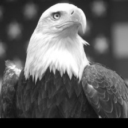

In [9]:
ToPILImage()(query_images[0])

In [10]:
predicted_label = Learner.predict_single_image(
    support_images.cuda(), 
    support_labels.cuda(), 
    query_images[0].cuda(), 
    proton_classifier_1.cuda()
  )

print (f"Predicted label: {predicted_label.item()}")
print (f"True label: {query_labels[0].item()}")

Predicted label: 0
True label: 0
